# Cross-validation techniques

This lesson focuses on the practical implementation of cross-validation approaches for model performance quantification. Most of the material is based on the scikit-learn page (https://scikit-learn.org/stable/modules/cross_validation.html).

Similarly as in bootstrap, cross-validation assesses the quality of a model (e.g. the bias and the variance) by only using the available data.  Instead of resampling our data with replacement, the model is trained on a subset of our data sampled _without replacement_. The testing of the model is then performed on the hold-out subset of the data not used for training.

We have seen how this procedure an be easily implemented via the $\mbox{np.random.choice}$ function.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

iris = datasets.load_iris()
print("The size of X is: " + str(iris.data.shape) + "\nThe size of the target is: " + str(iris.target.shape))

The size of X is: (150, 4)
The size of the target is: (150,)


In [2]:
# We choose to perform training on 60% of the data
hold_out = 0.4
len_training = int((1-hold_out) * iris.data.shape[0])

training_index = np.random.choice(range(iris.data.shape[0]), len_training, replace=False)
testing_index = np.setdiff1d(range(iris.data.shape[0]),training_index, assume_unique=True)

print("Training indices:\n" + str(np.sort(training_index)))
print("Testing indices:\n" + str(np.sort(testing_index)))

X_train = iris.data[training_index,:]
y_train = iris.target[training_index]

X_test = iris.data[testing_index,:]
y_test = iris.target[testing_index]


print("The training dimension is: " + str(X_train.shape))
print("The testing dimension is: " + str(X_test.shape))


Training indices:
[  0   4   7   8   9  10  11  12  13  15  16  18  20  21  26  27  28  29
  30  31  32  33  34  36  37  39  41  42  45  47  48  49  50  54  58  59
  62  63  64  65  66  67  68  72  73  76  78  79  81  84  85  86  87  88
  89  90  91  93  94  95  97 101 102 105 106 108 111 114 115 116 117 120
 121 122 123 125 126 128 129 132 134 136 138 140 142 143 144 145 147 149]
Testing indices:
[  1   2   3   5   6  14  17  19  22  23  24  25  35  38  40  43  44  46
  51  52  53  55  56  57  60  61  69  70  71  74  75  77  80  82  83  92
  96  98  99 100 103 104 107 109 110 112 113 118 119 124 127 130 131 133
 135 137 139 141 146 148]
The training dimension is: (90, 4)
The testing dimension is: (60, 4)


In [3]:
from sklearn.model_selection import train_test_split

## Equivalent sklearn command
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.4, random_state=412123)

print("The training dimension is: " + str(X_train.shape))
print("The testing dimension is: " + str(X_test.shape))

The training dimension is: (90, 4)
The testing dimension is: (60, 4)


$\textbf{Exercise.}$ Choose a classifier and compute training and testing accuracy for this data.

In [4]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

kn = KNeighborsClassifier(3)
kn.fit(X_train, y_train)
pred = kn.predict(X_train)

accuracy_score(y_train, pred)

0.9777777777777777

The obtained testing performance is however biased by the specific choice of the training/testing split. If we perform a different split we would probably get different results. Can you verify this?

In [5]:
accuracy_score(y_test, kn.predict(X_test))

0.9666666666666667

In [6]:
for split in range(1, 6):
    print(f"Validation split: {split/10}")
    X_train, X_test, y_train, y_test = train_test_split(iris.data, 
                                                        iris.target, 
                                                        test_size=split/10, 
                                                        random_state=1)
    kn = KNeighborsClassifier(3)
    kn.fit(X_train, y_train)
    print(f"acc score: {accuracy_score(y_test, kn.predict(X_test))}\n")

Validation split: 0.1
acc score: 1.0

Validation split: 0.2
acc score: 1.0

Validation split: 0.3
acc score: 0.9777777777777777

Validation split: 0.4
acc score: 0.9833333333333333

Validation split: 0.5
acc score: 0.92



Taking inspiration from the bootstrap technique, we can iterate over different samples of the data to obtain an estimator of the mean performance of our model. This approach is for example at the basis of _k-fold cross validation_. We split the data in _k_ __non overlapping__ smaller sets:

- we train the model on $k-1$ subsets
- we test it on the hold-out set



$\textbf{Exercise.}$ Write a routine to perform k-fold cross validation on the given data.

In [7]:
from sklearn.utils import shuffle
model = KNeighborsClassifier(n_neighbors=2)
np.random.seed(2123)
data_idx = np.arange(iris.data.shape[0])
# Shuffling the data
#### Mode 1
# shuffling the data indices
np.random.shuffle(data_idx)
# getting data and labels at shuffled indices
X_shuffled = iris.data[data_idx,:]
y_shuffled = iris.target[data_idx]
#### Mode 2
# #Stacking data and labels
# stacked_data = np.hstack([iris.data,iris.target.reshape(-1,1)])
# #Shuffling data and labels
# np.random.seed(2123)
# np.random.shuffle(stacked_data)
# #Separatig shuffled data from shuffled labels
# X_shuffled = stacked_data[:,:4]
# y_shuffled = stacked_data[:,4]
#### Mode 3
# From sklearn
#X_shuffled, y_shuffled = shuffle(iris.data, iris.target)
k = 10
fold_size = np.floor(X_shuffled.shape[0]/k)
print('The fold size is:', fold_size)
training_acc = []
testing_acc = []
for i in range(k):
    # We compute the index where the testing data starts
    begin = int(i*fold_size)
    # We compute the index where the testing data stops
    end = int((i+1)*fold_size)
    print(begin,end)
    # We extract the testing data in the range [begin, start]
    testing_data = X_shuffled[begin:end,:]
    # We extract the testing labels in the range [begin, start]
    testing_labels = y_shuffled[begin:end]
    # We compute the training indices as the remaining idices of
    # our data when we remove the testing ones
    training_indices = np.setdiff1d(range(X_shuffled.shape[0]),range(begin,end), assume_unique=True)
    # We extract the testing data in the range [begin, start]
    training_data = X_shuffled[training_indices,:]
    # We extract the testing labels in the range [begin, start]
    training_labels = y_shuffled[training_indices]
    # We train the model on the training data
    model.fit(training_data, training_labels)
    # We compute the accuracy in the training data
    training_acc.append(model.score(training_data, training_labels))
    # We compute the accuracy in the testing data
    testing_acc.append(model.score(testing_data, testing_labels))
print(training_acc)
print(testing_acc)
print('Average training accuracy', np.mean(training_acc))
print('SD training accuracy', np.std(training_acc))
print('Average testing accuracy', np.mean(testing_acc))
print('SD testing accuracy', np.std(testing_acc))

The fold size is: 15.0
0 15
15 30
30 45
45 60
60 75
75 90
90 105
105 120
120 135
135 150
[0.9777777777777777, 0.9777777777777777, 0.9703703703703703, 0.9851851851851852, 0.9777777777777777, 0.9777777777777777, 0.9851851851851852, 0.9851851851851852, 0.9777777777777777, 0.9777777777777777]
[1.0, 0.9333333333333333, 1.0, 0.8666666666666667, 0.9333333333333333, 0.9333333333333333, 0.8, 0.9333333333333333, 1.0, 1.0]
Average training accuracy 0.9792592592592593
SD training accuracy 0.0044444444444444505
Average testing accuracy 0.9400000000000001
SD testing accuracy 0.06289320754704401


In [8]:
from sklearn.model_selection import cross_val_score

sklearn_accuracy = cross_val_score(model, iris.data, iris.target, scoring = 'accuracy', cv=10)

print("The accuracy from " + str(k) + "-fold cross validation is: \n" + str(sklearn_accuracy))

print("The average accuracy from " + str(k) + "-fold cross validation is: " + str(np.mean(sklearn_accuracy)))

The accuracy from 10-fold cross validation is: 
[1.         0.93333333 1.         0.93333333 0.86666667 1.
 0.86666667 0.93333333 1.         1.        ]
The average accuracy from 10-fold cross validation is: 0.9533333333333334


K-fold cross-validation can be also repeated several times, and the average cross-validation accuracy can be reported. 

In [9]:
from sklearn.model_selection import RepeatedKFold

X = np.array([[1, 2], [3, 4], [1, 2], [3, 4]])
y = np.array([0, 0, 1, 1])

rkf = RepeatedKFold(n_splits=2, n_repeats=2, random_state=2652124)
for train_index, test_index in rkf.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

TRAIN: [0 1] TEST: [2 3]
TRAIN: [2 3] TEST: [0 1]
TRAIN: [1 2] TEST: [0 3]
TRAIN: [0 3] TEST: [1 2]


$\mathbf{Exercise.}$ Write a repeated K-fold strategy for the iris dataset.

In [10]:
# training_acc = []
# testing_acc = []

# rkf = RepeatedKFold(n_splits=2, n_repeats=2, random_state=2652124)

# for train_index, test_index in rkf.split(X):
#     print("TRAIN:", train_index, "TEST:", test_index)
#     X_train, X_test = X[train_index], X[test_index]
#     y_train, y_test = y[train_index], y[test_index]
#         # We train the model on the training data
#     model.fit(X_train, y_train)
#     # We compute the accuracy in the training data
#     training_acc.append(model.score(X_train, y_train))
#     # We compute the accuracy in the testing data
#     testing_acc.append(model.score(X_test, y_test))
    
# print(training_acc)
# print(testing_acc)
# print('Average training accuracy', np.mean(training_acc))
# print('SD training accuracy', np.std(training_acc))
# print('Average testing accuracy', np.mean(testing_acc))
# print('SD testing accuracy', np.std(testing_acc))

rkf = RepeatedKFold(n_splits=10, n_repeats=2, random_state=2652124)
accuracy = []
for train_index, test_index in rkf.split(iris.data):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train  = iris.data[train_index,:]
    y_train =  iris.target[train_index]
    X_test = iris.data[test_index,:]
    y_test = iris.target[test_index]
    kn.fit(X_train, y_train)
    pred_test = kn.predict(X_test)
    accuracy.append(accuracy_score(y_test , pred_test))
print(np.mean(accuracy), np.std(accuracy))

0.96 0.04422166387140532


## Leave one out

We have seen during the previous lesson that removing a single point from the dataset can have a drastic impact on the modeling variability. This fact motivates another standard cross-validation strategy called _leave one out_ (LOO). In LOO the model is trained on a subset of the data containing all but a single data point. The testing is performed on the single hold-out point. We therefore obtain  $\mbox{N_sample}$ predictions.


$\textbf{Exercise.}$ Write a LOO routine for this data.

The fold size is: 1.0
Average training accuracy 0.9799108148281612
SD training accuracy 0.00122860967496832
Average testing accuracy 0.9463087248322147
SD testing accuracy 0.22540745803686799


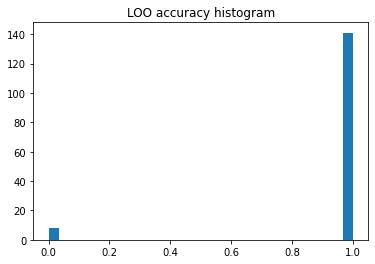

The average LOO accuracy is: 0.9463087248322147


In [11]:
from sklearn.neighbors import KNeighborsClassifier

loo_accuracy = []

model = KNeighborsClassifier(n_neighbors=2)

from sklearn.utils import shuffle

model = KNeighborsClassifier(n_neighbors=2)
np.random.seed(2123)

data_idx = np.arange(iris.data.shape[0])

# Shuffling the data
#### Mode 1 
# shuffling the data indices
np.random.shuffle(data_idx)
# getting data and labels at shuffled indices
X_shuffled = iris.data[data_idx,:]
y_shuffled = iris.target[data_idx]

#### Mode 2 
# Stacking data and labels
#stacked_data = np.hstack([iris.data,iris.target.reshape(-1,1)])
# Shuffling data and labels
#np.random.seed(2123)
#np.random.shuffle(stacked_data)
# Separatig shuffled data from shuffled labels
#X_shuffled = stacked_data[:,:4]
#y_shuffled = stacked_data[:,4]

#### Mode 3
# From sklearn
#shuffled_data, shuffled_target = shuffle(iris.data, iris.target)

k = X_shuffled.shape[0]-1

fold_size = np.floor(X_shuffled.shape[0]/k)

print('The fold size is:', fold_size)

training_acc = []
testing_acc = []

for i in range(k):
    # We compute the index where the testing data starts  
    begin = int(i*fold_size) 
    # We compute the index where the testing data stops 
    end = int((i+1)*fold_size)
    
    # We extract the testing data in the range [begin, start]  
    testing_data = X_shuffled[begin:end,:]
    # We extract the testing labels in the range [begin, start]
    testing_labels = y_shuffled[begin:end]
    
    # We compute the training indices as the remaining idices of 
    # our data when we remove the testing ones
    training_indices = np.setdiff1d(range(X_shuffled.shape[0]),range(begin,end), assume_unique=True)
  
    # We extract the testing data in the range [begin, start]  
    training_data = X_shuffled[training_indices,:]
    # We extract the testing labels in the range [begin, start]
    training_labels = y_shuffled[training_indices]
    
    # We train the model on the training data
    model.fit(training_data, training_labels)
    
    # We compute the accuracy in the training data
    training_acc.append(model.score(training_data, training_labels))
    # We compute the accuracy in the testing data
    testing_acc.append(model.score(testing_data, testing_labels))
                       

        
print('Average training accuracy', np.mean(training_acc))    
print('SD training accuracy', np.std(training_acc))
print('Average testing accuracy', np.mean(testing_acc))    
print('SD testing accuracy', np.std(testing_acc))


plt.hist(testing_acc, bins=30)
plt.title('LOO accuracy histogram')
plt.show()

print('The average LOO accuracy is: ' + str(np.mean(testing_acc)))
 

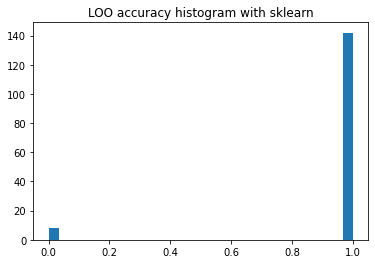

The average LOO accuracy with sklearn is: 0.9466666666666667


In [12]:
## Sklearn implementation

##Note: ``LeaveOneOut()`` is equivalent to ``KFold(n_splits=n)``

from sklearn.model_selection import LeaveOneOut

loo = LeaveOneOut()
model = KNeighborsClassifier(n_neighbors=2)

loo_accuracy_sklearn = []
for train, test in loo.split(iris.data):
    
    model.fit(iris.data[train,:], iris.target[train])
    loo_accuracy.append(model.score(iris.data[test,:], iris.target[test]))
    

plt.hist(loo_accuracy, bins=30)
plt.title('LOO accuracy histogram with sklearn')
plt.show()

print('The average LOO accuracy with sklearn is: ' + str(np.mean(loo_accuracy)))

## Receiving Operator Characteristic (ROC) 

ROC curves are typically computed by evaluating the false positive rate and the true positive rate, plotted respectively on the X and Y axis. Remember that both True positive rate and false positive rate take values in [0,1]. An optimal classifier whould ideally keep the false positive rate as low as possible (ideally zero), and the true positive rate as large as possible (ideally one). Therefore, the maximum value of the area defined by the ROC curve (area under the curve - AUC -) is 1, which is the area of a square of side equal to 1. In general the area under the ROC curve takes values in [0,1] too, the larger the better.

We recall from lesson 2:

- Accuracy: quantifies the overall number of correct predictions
$$ ACC = \frac{\mbox{True Positives} + \mbox{True negatives}}{\mbox{Total sample size}}$$


- Precision (positive predictive value): quantifies the number of correct predictions among all the positive predictions
$$ PRECISION = \frac{\mbox{True Positives}}{\mbox{True Positives} + \mbox{False Positives} } $$


- Recall (true positive rate, or sensitivity): quantifies the number of correct predictions among all the positive data
$$ RECALL = \frac{\mbox{True Positives}}{\mbox{True Positives} + \mbox{False Negatives} } $$


- Specificity (true negative rate): quantifies the number of correct predictions among all the negative data
$$ SPEC = \frac{\mbox{True Negatives}}{\mbox{False Positives} + \mbox{True Negatives} } $$



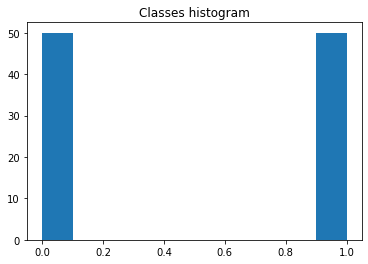

Original shape of X: (100, 4)
New shape of X: (100, 804)


In [13]:
import numpy as np
from scipy import interp

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

# #############################################################################
# Data IO and generation

# Import the data
iris = datasets.load_iris()
X = iris.data
y = iris.target
X, y = X[y != 2], y[y != 2]

n_samples, n_features = X.shape

plt.hist(y)
plt.title('Classes histogram')
plt.show()

# Add noisy features
random_state = np.random.RandomState(0)

print('Original shape of X: ' + str(X.shape))
X = np.c_[X, random_state.randn(n_samples, 200 * n_features)]
print('New shape of X: ' + str(X.shape))


Probabilistic predictions:
[[0.97308524 0.02691476]
 [0.97305174 0.02694826]
 [0.97306654 0.02693346]
 [0.97308466 0.02691534]
 [0.97310595 0.02689405]
 [0.97304255 0.02695745]
 [0.97310708 0.02689292]
 [0.973055   0.026945  ]
 [0.97306956 0.02693044]
 [0.97309513 0.02690487]
 [0.97304512 0.02695488]
 [0.97311034 0.02688966]
 [0.9730619  0.0269381 ]
 [0.97306908 0.02693092]
 [0.97307497 0.02692503]
 [0.97305174 0.02694826]
 [0.9730216  0.0269784 ]
 [0.97310084 0.02689916]
 [0.9730723  0.0269277 ]
 [0.97304369 0.02695631]
 [0.97303958 0.02696042]
 [0.97306994 0.02693006]
 [0.97307095 0.02692905]
 [0.97306963 0.02693037]
 [0.97307197 0.02692803]
 [0.97306993 0.02693007]
 [0.97307575 0.02692425]
 [0.97305166 0.02694834]
 [0.9730502  0.0269498 ]
 [0.97307706 0.02692294]
 [0.97307391 0.02692609]
 [0.97305809 0.02694191]
 [0.97306947 0.02693053]
 [0.97306209 0.02693791]
 [0.97309878 0.02690122]
 [0.97307454 0.02692546]
 [0.97306585 0.02693415]
 [0.97306936 0.02693064]
 [0.97307086 0.02692914

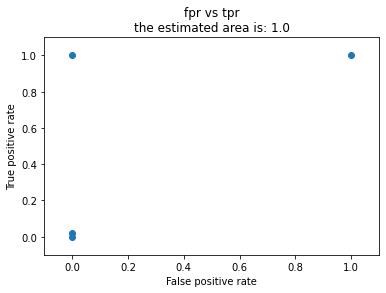

In [14]:
# #############################################################################
# Classification and ROC analysis
classifier = svm.SVC(kernel='linear', probability=True,
                     random_state=random_state)

#Evaluating the classifier on the full data sample
probas_ = classifier.fit(X, y)

probas_ = classifier.predict_proba(X)

print("Probabilistic predictions:\n" + str(probas_))

fpr, tpr, thresholds = roc_curve(y, probas_[:,1])

print('fpr: ' + str(fpr))
print('tpr: ' + str(tpr))
print('thr: ' + str(thresholds))

area_under_the_curve = auc(fpr, tpr)

plt.scatter(fpr,tpr)
plt.xlim([-0.1,1.1])
plt.xlabel('False positive rate')
plt.ylim([-0.1,1.1])
plt.ylabel('True positive rate')
plt.title('fpr vs tpr\nthe estimated area is: ' + str(area_under_the_curve))
plt.show()


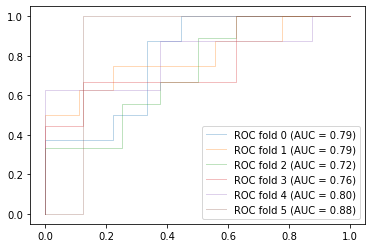

The estimated tpr for fold 0: 
[0.    0.375 0.375 0.375 0.375 0.375 0.375 0.375 0.375 0.375 0.375 0.375
 0.375 0.375 0.375 0.375 0.375 0.375 0.375 0.375 0.375 0.375 0.5   0.5
 0.5   0.5   0.5   0.5   0.5   0.5   0.5   0.5   0.5   0.875 0.875 0.875
 0.875 0.875 0.875 0.875 0.875 0.875 0.875 0.875 1.    1.    1.    1.
 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.    1.   ]


In [15]:
# Within a cross-validation loop
# Run classifier with cross-validation and plot ROC curves

cv = StratifiedKFold(n_splits=6)

roc_sample = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
i = 0

for train, test in cv.split(X, y):
    probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
    # Compute ROC curve and area under the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    roc_sample.append(np.interp(mean_fpr, fpr, tpr))
    # We impose the ROC curve to start from 0
    roc_sample[-1][0] = 0.0
    # Compute the area under the curve
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    # Plotting the ROC curve
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1

plt.legend()
plt.show()

print('The estimated tpr for fold 0: ')
print(roc_sample[0])

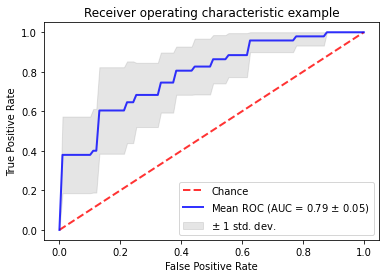

In [16]:
# Summarizing the cross-validation results

# Adding diagonal line of random classification 
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

# Computing mean and std for the curves
mean_tpr = np.mean(roc_sample, axis=0)
std_tpr = np.std(roc_sample, axis=0)

# We impose the end point of the average ROC to be equal to 1
mean_tpr[-1] = 1.0

# Computing the AUC of the average curves
mean_auc = auc(mean_fpr, mean_tpr)
# Computing the std of the AUCs 
std_auc = np.std(aucs)

plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)


# Nice plot of curve with std
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

## Stratification

When the data is unbalanced, k-fold cross-validation may pose problems of biased accuracy quantification

In [17]:
from sklearn.datasets import make_classification
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import recall_score


X, y = make_classification(n_samples = 100, n_features=2, n_redundant=0, n_informative=2, \
                           random_state=0, n_clusters_per_class=1, weights = [0.9])


model = KNeighborsClassifier(n_neighbors=5)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=4)
clf = model.fit(X_train, y_train)

print("*** Training ***")
print("Elements of class 0: " + str(np.sum(y_train==0)/len(y_train)))
print("Elements of class 1: " + str(np.sum(y_train==1)/len(y_train)))

print("*** Testing ***")
print("Elements of class 0: " + str(np.sum(y_test==0)/len(y_test)))
print("Elements of class 1: " + str(np.sum(y_test==1)/len(y_test)))





*** Training ***
Elements of class 0: 0.9
Elements of class 1: 0.1
*** Testing ***
Elements of class 0: 0.92
Elements of class 1: 0.08


We observe that the classes are not equally represented in training and testing data. This may pose a problem in the evaluation of the classifier, as the performance is not evaluated on the data with same distribution. For this reason, we would like to keep the proportion of classes constant across data split. This operation is called _stratified k-fold_.


$\textbf{Exercise.}$ Write a routine for stratified k-fold cross-validation.

In [18]:
ratio = np.sum(y==1)/len(y)
test_size = 0.5 * len(y)

pos_test_size = int(ratio*test_size)
neg_test_size = int((1-ratio) * test_size)

print("We need to train with " + str(pos_test_size) + " samples from class 1, and " + str(neg_test_size) + \
      " samples from class 0.")

idx_pos_train = np.random.choice(np.where(y==1)[0], pos_test_size, replace = False)
idx_neg_train = np.random.choice(np.where(y==0)[0], neg_test_size, replace = False)

train_indices = np.concatenate([idx_pos_train,idx_neg_train])

y_train = y[train_indices]
X_train = X[train_indices,:]

idx_pos_test = np.setdiff1d(np.where(y==1)[0],idx_pos_train, assume_unique = True)
idx_neg_test = np.setdiff1d(np.where(y==0)[0], idx_neg_train, assume_unique = True)

test_indices = np.concatenate([idx_pos_test,idx_neg_test])
y_test = y[test_indices]
X_test = X[test_indices,:]


print("*** Training ***")
print("Elements of class 0: " + str(np.sum(y_train==0)/len(y_train)))
print("Elements of class 1: " + str(np.sum(y_train==1)/len(y_train)))

print("*** Testing ***")
print("Elements of class 0: " + str(np.sum(y_test==0)/len(y_test)))
print("Elements of class 1: " + str(np.sum(y_test==1)/len(y_test)))

We need to train with 4 samples from class 1, and 45 samples from class 0.
*** Training ***
Elements of class 0: 0.9183673469387755
Elements of class 1: 0.08163265306122448
*** Testing ***
Elements of class 0: 0.9019607843137255
Elements of class 1: 0.09803921568627451


In [19]:
from sklearn.model_selection import StratifiedKFold

X = np.ones(12)
y = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1])

skf = StratifiedKFold(n_splits=4)
for train, test in skf.split(X, y):
    print("\n%s %s" % (train, test))
    print("*** Training ***")
    print("Elements of class 0: " + str(np.sum(y[train]==0)/len(y[train])))
    print("Elements of class 1: " + str(np.sum(y[train]==1)/len(y[train])))

    print("*** Testing ***")
    print("Elements of class 0: " + str(np.sum(y[test]==0)/len(y[test])))
    print("Elements of class 1: " + str(np.sum(y[test]==1)/len(y[test])))


[ 1  2  3  6  7  8  9 10 11] [0 4 5]
*** Training ***
Elements of class 0: 0.3333333333333333
Elements of class 1: 0.6666666666666666
*** Testing ***
Elements of class 0: 0.3333333333333333
Elements of class 1: 0.6666666666666666

[ 0  2  3  4  5  8  9 10 11] [1 6 7]
*** Training ***
Elements of class 0: 0.3333333333333333
Elements of class 1: 0.6666666666666666
*** Testing ***
Elements of class 0: 0.3333333333333333
Elements of class 1: 0.6666666666666666

[ 0  1  3  4  5  6  7 10 11] [2 8 9]
*** Training ***
Elements of class 0: 0.3333333333333333
Elements of class 1: 0.6666666666666666
*** Testing ***
Elements of class 0: 0.3333333333333333
Elements of class 1: 0.6666666666666666

[0 1 2 4 5 6 7 8 9] [ 3 10 11]
*** Training ***
Elements of class 0: 0.3333333333333333
Elements of class 1: 0.6666666666666666
*** Testing ***
Elements of class 0: 0.3333333333333333
Elements of class 1: 0.6666666666666666


The problem of unbalanced data is critical when assessing a classification metric. We recall that the accuracy is defined as: 

$$ ACC = \frac{\mbox{True Positives} + \mbox{True negatives}}{\mbox{Total sample size}}.$$

If there is unbalance in the data, for example the positive class represents 90% of the population, a classifier predicting constantly positive will lead to an accuracy of $.9$ without however correctly predicting any of the samples of the negative class. This may represent a serious issue, for example in _fraud detection_ problems, where we are interested in predicting classes which are very rare (the frauds).


In [20]:
X, y = make_classification(n_samples = 400, n_features=2, n_redundant=0, n_informative=2, \
                           random_state=0, n_clusters_per_class=1, weights = [0.90])


clf = svm.SVC(kernel='linear', probability=True,
                     random_state=random_state)

skf = StratifiedKFold(n_splits=2)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=43, stratify = y)
clf = clf.fit(X_train, y_train)


print("Accuracy:\n    (tp + tn)/tot: " + str(clf.score(X_test, y_test)))

Accuracy:
    (tp + tn)/tot: 0.945


In this case, better metrics are the Precision (false positive rate) and Recall (false negative rate):

In [21]:
print("\n *** False positive and False negative rates ***")

P = precision_score(clf.predict(X_test), y_test)
R = recall_score(clf.predict(X_test), y_test)

print("Precision\n    tp / (tp + fp)): " + str(P))
print("Recall\n    tp / (tp + fn): " + str(R))




 *** False positive and False negative rates ***
Precision
    tp / (tp + fp)): 0.47619047619047616
Recall
    tp / (tp + fn): 1.0


These quantities are also related to the F1 score, which is defined as the harmonic mean of precision and recall:
$$ F1 = 2\frac{Prec * Rec}{Prec + Rec}$$


In [22]:
print("F1: " + str(2*P*R/(P+R)))

F1: 0.6451612903225806


In the unbalanced case, the ROC AUC is also not appropriate for the quantification of the performance:

<ipython-input-23-7ac4f788d17c>:11: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  roc_sample.append(interp(mean_fpr, fpr, tpr))
<ipython-input-23-7ac4f788d17c>:11: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  roc_sample.append(interp(mean_fpr, fpr, tpr))
<ipython-input-23-7ac4f788d17c>:11: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  roc_sample.append(interp(mean_fpr, fpr, tpr))
<ipython-input-23-7ac4f788d17c>:11: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  roc_sample.append(interp(mean_fpr, fpr, tpr))
<ipython-input-23-7ac4f788d17c>:11: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  roc_sample.append(interp(mean_fpr, fpr, tpr))
<ipython-input-23-7ac4f788d17c>:11: Depr

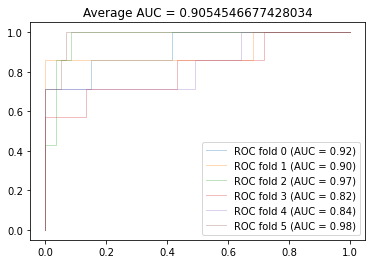

In [23]:
cv = StratifiedKFold(n_splits=6)
roc_sample = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
i = 0

for train, test in cv.split(X, y):
    probas_ = clf.fit(X[train], y[train]).predict_proba(X[test])
    # Compute ROC curve and area under the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    roc_sample.append(interp(mean_fpr, fpr, tpr))
    # We impose the ROC curve to start from 0
    roc_sample[-1][0] = 0.0
    # Compute the area under the curve
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    # Plotting the ROC curve
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1

plt.legend()
plt.title("Average AUC = " + str(np.mean(aucs)))
plt.show()


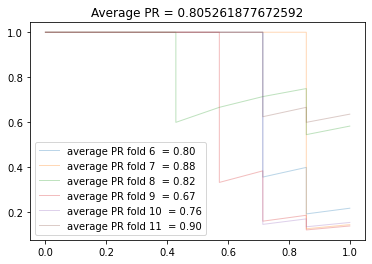

In [24]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

avg_pr = []
mean_R = np.linspace(0, 1, 100)

for train, test in cv.split(X, y):
    probas_ = clf.fit(X[train], y[train]).predict_proba(X[test])
    # Compute ROC curve and area under the curve
    P, R, thresholds = precision_recall_curve(y[test], probas_[:, 1])

    average_precision = average_precision_score(y[test], probas_[:, 1])
    avg_pr.append(average_precision)
    # Plotting the ROC curve
    plt.plot(R, P, lw=1, alpha=0.3,
             label='average PR fold %d  = %0.2f' % (i, average_precision))

    i += 1

plt.legend()
plt.title("Average PR = " + str(np.mean(avg_pr)))
plt.show()

